# Pytorch로 학습하기

키를 통해 몸무게를 예측하는 프로젝트를 통해 Pytorch를 통해 학습하는 과정을 이해하고, 주요 컴포넌트를 익힙니다.

Pytorch의 주요 컴포넌트:
- Dataset, Dataloader
- Model
- Loss
- Optimizer

## Dataset, Dataloader

Dataset과 Dataloader는 데이터와 관련된 컴포넌트 입니다.

Dataset은 학습을 위한 데이터 전체를 묶어놓은 컴포넌트 이고, Dataloader는 Dataset을 학습과정에서 설정한 세팅 (Hyperparameter, 하이퍼파라미터)으로 load하고 변형(transform)시키는 모듈입니다.

Pytorch에서는 `torch.utils.data`에 관련 모듈이 있습니다.

## Model

Model은 학습의 최종 결과물, 데이터를 통해 학습됩니다.

Model 내부의 학습가능 한 Parameter (trainable Parameter)를 Optimizer가 업데이트 시키면서 학습이 진행됩니다.

`nn.Module` 클래스를 상속하여 모델을 생성합니다.

## Loss

Loss는 Loss function, Cost function, Error function, Objective function 등 다양한 이름으로 불립니다.
예측 모델과 정답과의 차이를 나타내며, 경사하강법(Gradient Descent)을 이용하는 딥러닝에서는 Loss가 작아지는 방향으로 학습을 하게됩니다.

## Optimizer

Optimizer는 딥러닝을 최적화하는 다양한 알고리즘입니다. Loss를 통해 모델의 각 가중치가 어떤 뱡향으로 얼만큼 이동해야하는지 계산이 되는데 Optimizer는 이 값을 적절히 조정하여 최종적으로 모델의 가중치를 업데이트합니다.

그럼 키를 통해 몸무게를 예측하는 프로젝트를 통해 각 컴포넌트가 실제로 어떻게 사용되는지 알아보겠습니다.

# 키몸무게 프로젝트

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

## 데이터셋 정의
키와 몸무게 데이터셋을 살펴보겠습니다.

8개의 샘플이 있으며 아래와 같은 분포를 보입니다.

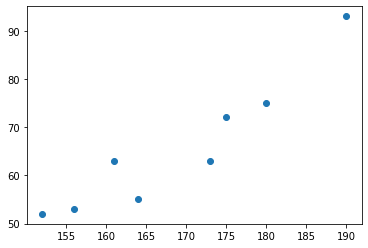

In [50]:
# 키와 몸무게 데이터셋
raw_data = torch.tensor([
    [180., 75.],
    [173., 63.],
    [152., 52.],
    [164., 55.],    
    [190., 93.],
    [175., 72.],
    [161., 63.],
    [156., 53.],
])

# Data visualization
import matplotlib.pyplot as plt
plt.scatter(raw_data[:, 0], raw_data[:, 1])
plt.show()

데이터가 Linear(선형) 관계를 어느정도 보이는 것 같습니다. 
예측할 모델을 선택하기 전에 데이터를 살펴보고 어떤 모델이 가장 데이터를 잘 표현하게 될지 정하게 됩니다.

선형 관계를 갖는 데이터를 잘 표현하는 모델로 Linear Regression 모델이 있습니다. 아래 모델 정의 부분에서 자세히 살펴보겠습니다.

그전에 데이터를 TrainSet과 TestSet으로 분리하고 전처리를 진행하겠습니다.

## 데이터셋 분리 및 전처리

예측 모델을 검증하기위해 일반적으로 데이터셋을 두개 혹은 세개로 분리하여 학습 및 검증을 수행합니다.

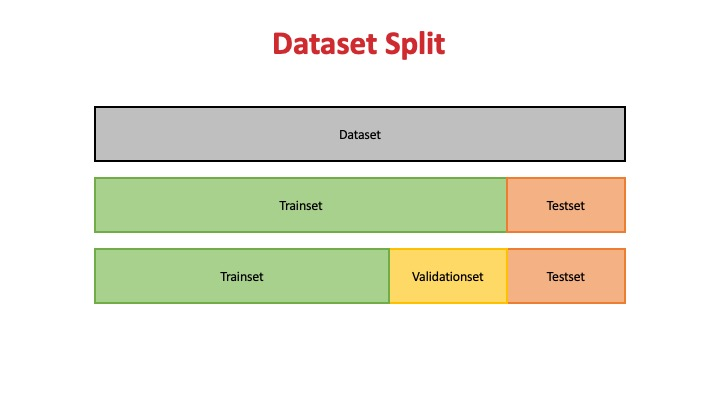


<div><img src="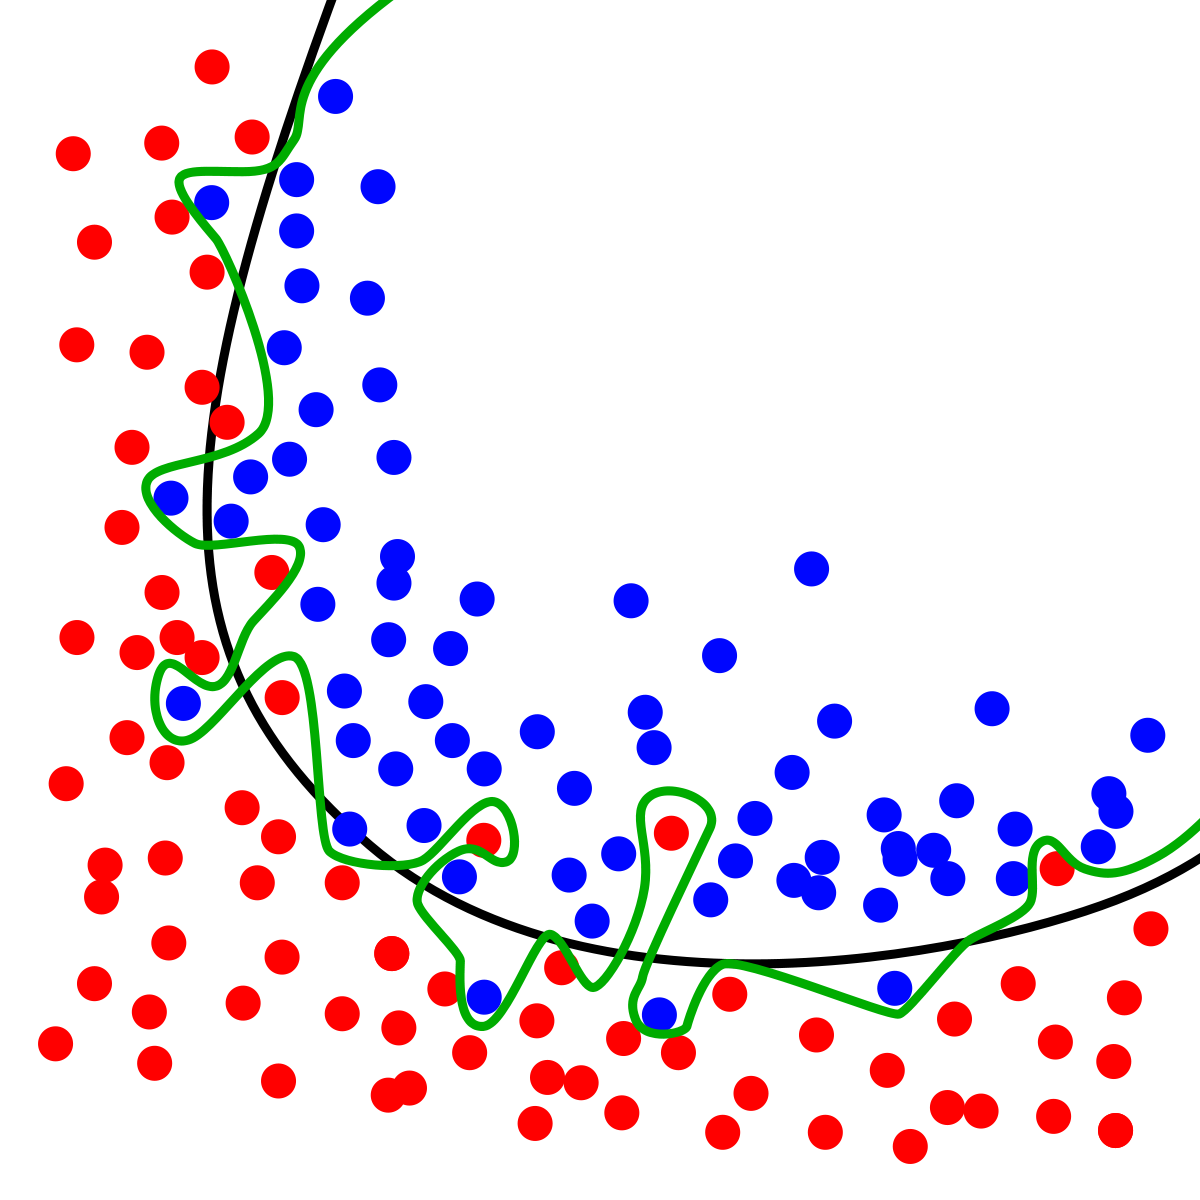)


### Underfitting, Overfitting

fit은 머신러닝에서 모델이 데이터를 얼마나 잘 맞췄는가를 표현한 말로 모델이 데이터를 잘 못 맞춘다면 Underfitting이라고 하고, 데이터를 과하게 잘 맞춘경우를 Overfitting이라고 합니다. 

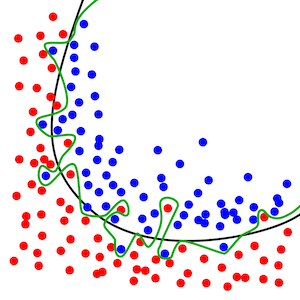

### 정규화와 표준화

데이터를 분리하기전에 데이터 정규화, 표준화 (Normalization, Standardization)을 수행합니다. 정규화와 표준화는 서로 다른 데이터의 범위를 맞춰주어 학습이 보다 용이하도록 하는 방법입니다. 우리 데이터셋의 경우 키는 cm, 몸무게는 Kg으로 단위도 다르고 범위도 다릅니다. 이런 데이터 범위를 통일 시키고 서로 다른 데이터끼리의 비교, 계산의 한계를 극복하기 위해 사용합니다. 

***정규화***는 데이터 범위를 0~1 사이로 옮깁니다. 학습중에 컴퓨터는 큰 값이 중요하다고 생각하고 그 값에 집중을 하는데, 이렇게 범위를 맞추면 특정 컬럼에 집중하지 않고 모든 데이터를 같은 기준으로 학습하게 됩니다.

***표준화***는 데이터가 정규분포를 갖는 다는 가정 하에 수행합니다. 데이터를 $N(0,1)$ 평균이 0이고 표준편차가 1인 정규분포로 이동시키고 학습을 진행합니다. 정규분포를 활용하는 것이기 때문에 모든 데이터가 0과 1사이에 있는 것은 아니며, 많은 데이터가 0 근처로 모이게 됩니다.

In [51]:
# normalization
def normalize(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def denormalize(data, min_val, max_val):
    return (data * (max_val - min_val)) + min_val

norm_x = normalize(raw_data[:, 0], 150, 200)
norm_y = normalize(raw_data[:, 1], 50, 100)

# 입력값인 특징 (features)과 결과값으로 나누기
train_x, test_x = norm_x[:5].unsqueeze(-1), norm_x[5:].unsqueeze(-1)
train_y, test_y = norm_y[:5], norm_y[5:]

In [52]:
train_x, train_y, test_x, test_y

(tensor([[0.6000],
         [0.4600],
         [0.0400],
         [0.2800],
         [0.8000]]),
 tensor([0.5000, 0.2600, 0.0400, 0.1000, 0.8600]),
 tensor([[0.5000],
         [0.2200],
         [0.1200]]),
 tensor([0.4400, 0.2600, 0.0600]))

In [53]:
train_dataset = TensorDataset(train_x, train_y)
test_dataset = TensorDataset(test_x, test_y)

## 모델정의

이번강의에서 사용될 모델은 Linear Regression 모델입니다.

Linear regression 모델은 직선의 방정식 $y = Wx +b$을 활용합니다.
모든 데이터에서 가장 오류가 작은 즉 데이터를 가장 잘 표현하는 직선을 학습하게됩니다.
학습되는 파라미터는 기울기를 나타내는 가중치 $W$와 편향, y절편을 나타내는 $b$ bias를 학습합니다.

In [54]:
class SimpleModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(1, 1, bias=True)
    
    def forward(self, x):
        return self.linear(x)

In [55]:
net = SimpleModel()

## Loss 함수, Optimizer 정의

In [56]:
critetion = nn.MSELoss()   # Regression Loss 중 하나인 Mean Square Error Loss를 사용
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)   # 기본 Optimizer인 Stocastic Gradient Descent Optimizer를 사용

## 학습

In [57]:
EPOCH = 100
BATCH_SIZE = 2

# Dataset을 Batch_size에 맞에 불러오고 셔플해주는 Dataloader를 정의
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# 학습 시작
for epoch in range(EPOCH):
    
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        
        # 데이터 가져오기
        inputs, labels = data
        
        # 모델 파라미터의 gradient 초기화
        optimizer.zero_grad()
        
        # forward + loss 계산 + backward + optimize
        outputs = net(inputs)
        loss = critetion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # 학습 통계 출력
        running_loss += loss.item()
        if epoch % 10 == 0:
            print(f'[{epoch + 1},{i + 1:2d}] loss: {running_loss/(i+1):.3f}')
        running_loss = 0.0

print("Training Finish")

[1, 1] loss: 0.077
[1, 2] loss: 0.004
[1, 3] loss: 0.221
[11, 1] loss: 0.049
[11, 2] loss: 0.053
[11, 3] loss: 0.041
[21, 1] loss: 0.175
[21, 2] loss: 0.038
[21, 3] loss: 0.000
[31, 1] loss: 0.187
[31, 2] loss: 0.021
[31, 3] loss: 0.000
[41, 1] loss: 0.009
[41, 2] loss: 0.080
[41, 3] loss: 0.014
[51, 1] loss: 0.027
[51, 2] loss: 0.035
[51, 3] loss: 0.022
[61, 1] loss: 0.101
[61, 2] loss: 0.062
[61, 3] loss: 0.045
[71, 1] loss: 0.049
[71, 2] loss: 0.120
[71, 3] loss: 0.002
[81, 1] loss: 0.082
[81, 2] loss: 0.113
[81, 3] loss: 0.020
[91, 1] loss: 0.046
[91, 2] loss: 0.090
[91, 3] loss: 0.001
Training Finish


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


## 검증

In [64]:
net.eval()

test_dataloader = DataLoader(test_dataset, batch_size=1)

for i, data in enumerate(test_dataloader):
    # 데이터 가져오기
    inputs, labels = data

    # forward
    outputs = net(inputs)
    loss = critetion(outputs, labels)

    # 학습 통계 출력
    running_loss += loss.item()
    print(f'[{i + 1:2d}] loss: {running_loss/(i+1):.3f}')
    running_loss = 0.0

[ 1] loss: 0.001
[ 2] loss: 0.002
[ 3] loss: 0.002


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [65]:
outputs = net(test_dataset.tensors[0])

In [66]:
print("predictions:", denormalize(outputs, 50, 100).flatten().data)
print("labels:", denormalize(test_dataset.tensors[1], 50 ,100))

predictions: tensor([70.5046, 60.2099, 56.5332])
labels: tensor([72., 63., 53.])


In [67]:
w, b = net.linear.weight, net.linear.bias
w = w.detach()[0]
b = b.detach()
print(w, b)

tensor([0.7353]) tensor([0.0424])


## 시각화

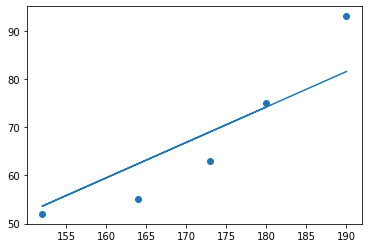

In [68]:
# Data visualization
import matplotlib.pyplot as plt
plt.scatter(denormalize(train_x, 150, 200), denormalize(train_y, 50, 100))
plt.plot(denormalize(train_x, 150, 200), denormalize(train_x*w+b, 50, 100))
plt.show()

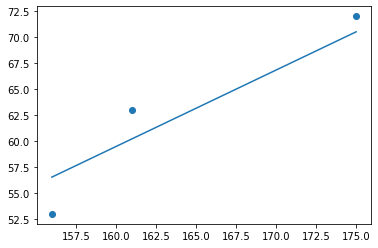

In [69]:
plt.scatter(denormalize(test_x, 150, 200), denormalize(test_y, 50, 100))
plt.plot(denormalize(test_x, 150, 200), denormalize(test_x*w+b, 50, 100))
plt.show()